# Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- ** Apply a distortion correction to raw images. **
- ** Use color transforms, gradients, etc., to create a thresholded binary image. **
- ** Apply a perspective transform to the image ("birds-eye view"). **
- ** Detect lane pixels and fit to find the lane boundary. **
- ** Determine the curvature of the lane and vehicle position with respect to center. **
- ** Warp the detected lane boundaries back onto the original image. **
- ** Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position. **

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
import os

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Helper Functions

In [3]:
def show_images(imgs, titles=None, ncols=2):
    n = len(imgs)
    nrows = (n+1) // ncols
    f, ax = plt.subplots(nrows, 2, figsize=(15, 5 * nrows))
    f.tight_layout()

    for i in range(ncols * nrows):
        ax = plt.subplot(nrows, ncols, i + 1)
        if i < n:
            img = imgs[i]
            if img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img[:,:,::-1])
            if titles != None:
                ax.set_title(titles[i], fontsize=15)        
        ax.axis('off')
        
def show_image(img, title=''):
    show_images([img], [title])

def save_example_image(basename, postfix, img):
    fname = "examples/{}_{}.jpg".format(basename, postfix)
    img = np.uint8(img/np.max(img)*255)
    cv2.imwrite(fname, img)
    
def save_output_image(basename, postfix, img):
    fname = "output_images/{}_{}.jpg".format(basename, postfix)
    img = np.uint8(img/np.max(img)*255)
    cv2.imwrite(fname, img)

## 1. Distortion Correction

In [4]:
# read calibration coefficents and perspective matrix

fname = "camera_cal/dist_pickle.p"
dist_pickle = pickle.load( open( fname, "rb" ) )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']
M = dist_pickle['M']
Minv = dist_pickle['Minv']
img_size = dist_pickle['img_size']

print("'{}' is loaded.".format(fname))

'camera_cal/dist_pickle.p' is loaded.


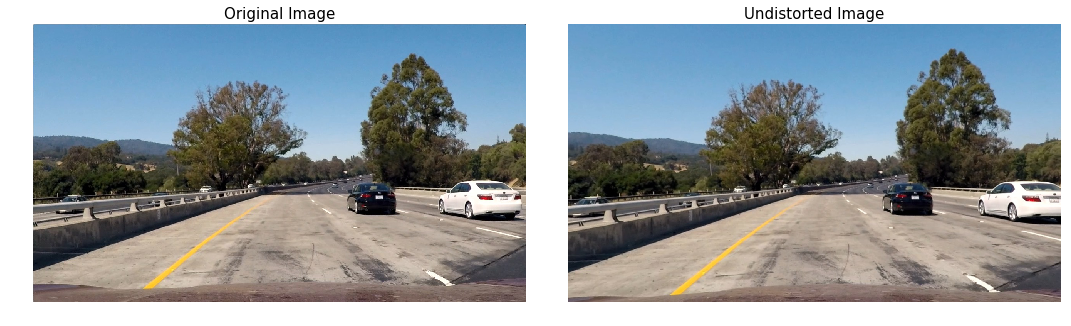

In [5]:
# read and images, and undistort it

basename = 'test1'
fname = 'test_images/{}.jpg'.format(basename)
img = cv2.imread(fname)

# undistorted it
undist = cv2.undistort(img, mtx, dist, None, mtx)

show_images([img, undist], ["Original Image", "Undistorted Image"])
save_example_image(basename, 'undist', undist)

## 2. Thresholded Binary Image

I thought this section was the most tricky part in this project.  I started some thresholds and test on them.  It worked on some images but failed on others at first.  After several trials, I decided to create the thresholded binary image by combining the X-Sobel, Y-Sobel and directional-Sobel on Saturation channel.

### Colorspace Transform

We compared channel images of gray, hue, luminace and saturation.  The saturation channel was the most suitable image for lane line detection

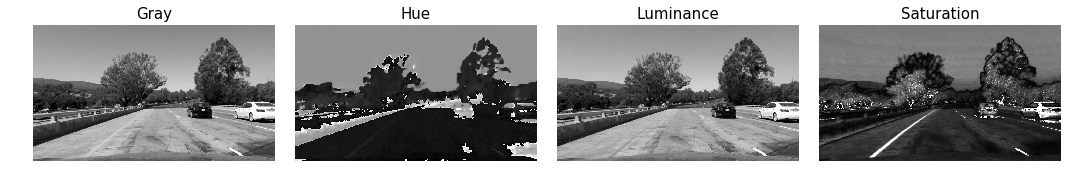

In [6]:
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
show_images([gray, hls[:,:,0], hls[:,:,1], hls[:,:,2]], 
            ["Gray", "Hue", "Luminance", "Saturation"], ncols = 4)
save_example_image(basename, 'gray', gray)
save_example_image(basename, 'hue', hls[:,:,0])
save_example_image(basename, 'lum', hls[:,:,1])
save_example_image(basename, 'sat', hls[:,:,2])

### Gradient Threshold

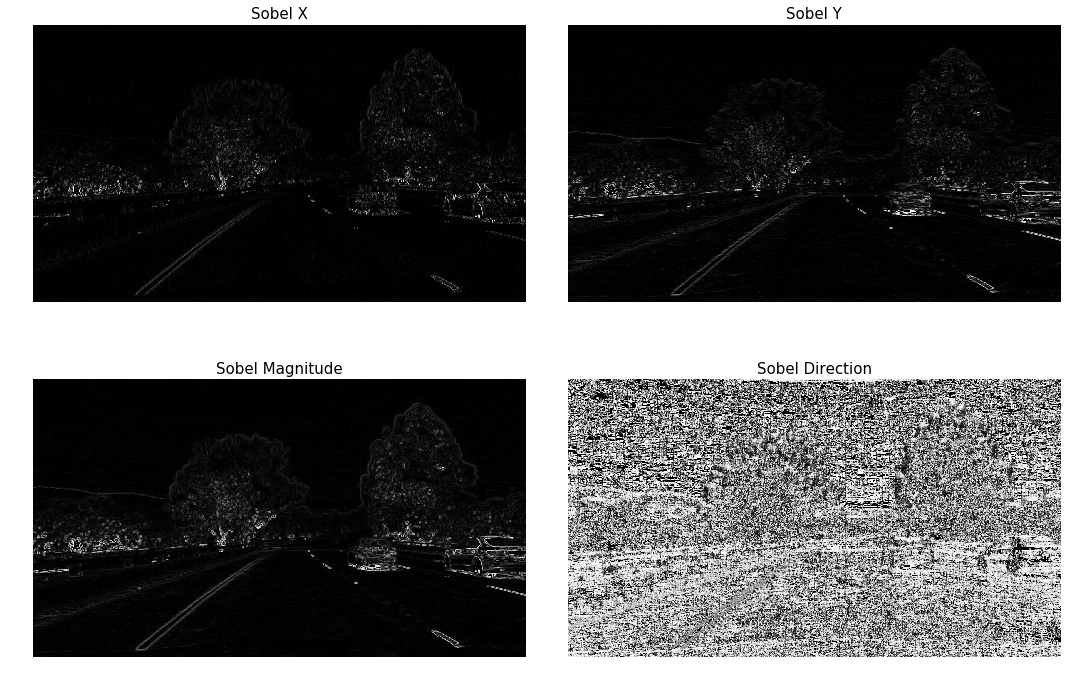

In [7]:
def sobel(img, ksize=3):
    '''
        return sobel_x, sobel_y, sobel_mag, sobel_dir
    '''
    sobel_x = np.abs(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize))
    sobel_y = np.abs(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize))
    sobel_mag = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    sobel_dir = np.arctan2(sobel_y, sobel_x)
    return sobel_x, sobel_y, sobel_mag, sobel_dir

saturation = hls[:,:,2]
sobel_x, sobel_y, sobel_mag, sobel_dir = sobel(saturation)
show_images([sobel_x, sobel_y, sobel_mag, sobel_dir], 
            ['Sobel X', 'Sobel Y', 'Sobel Magnitude', 'Sobel Direction'])

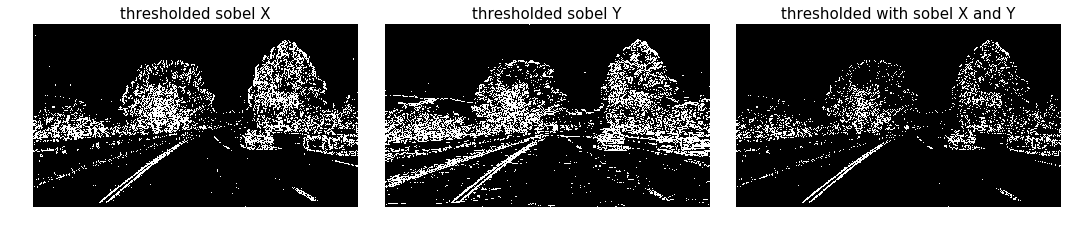

In [8]:
def thresh_image(img, thresh_min=0, thresh_max=255):
    scaled = np.uint8(img * 255 / np.max(img))
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh_min) & (scaled <= thresh_max)] = 1
    return binary

thresh_sobel_x = thresh_image(sobel_x, 10, 160)
thresh_sobel_y = thresh_image(sobel_y, 10, 160)
binary_xy = np.zeros_like(thresh_sobel_x)
binary_xy[(thresh_sobel_x==1) & (thresh_sobel_y==1)] = 1

show_images([thresh_sobel_x, thresh_sobel_y, binary_xy], 
            ["thresholded sobel X", "thresholded sobel Y", "thresholded with sobel X and Y"], ncols=3)
save_example_image(basename, 'sobelx', thresh_sobel_x)
save_example_image(basename, 'sobely', thresh_sobel_y)
save_example_image(basename, 'sobelxy', binary_xy)

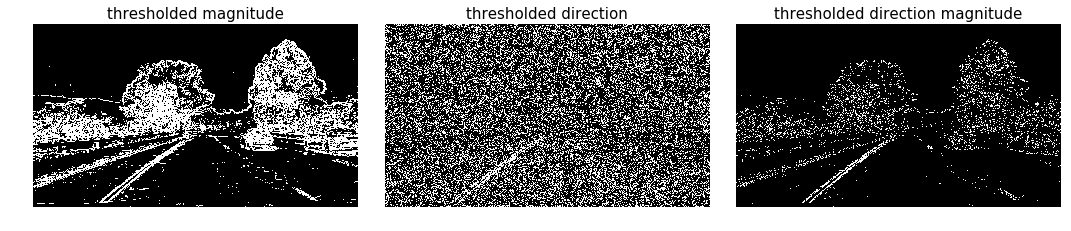

In [9]:
thresh_sobel_mag = thresh_image(sobel_mag, 10, 160)
thresh_sobel_dir = thresh_image(sobel_dir, 120, 195)
binary_mag = np.zeros_like(thresh_sobel_mag)
binary_mag[(thresh_sobel_mag==1) & (thresh_sobel_dir==1)] = 1

show_images([thresh_sobel_mag, thresh_sobel_dir, binary_mag], 
            ["thresholded magnitude", "thresholded direction", "thresholded direction magnitude"], ncols=3)
save_example_image(basename, 'sobel_mag', thresh_sobel_mag)
save_example_image(basename, 'sobel_dir', thresh_sobel_dir)
save_example_image(basename, 'sobel_magdir', binary_mag)

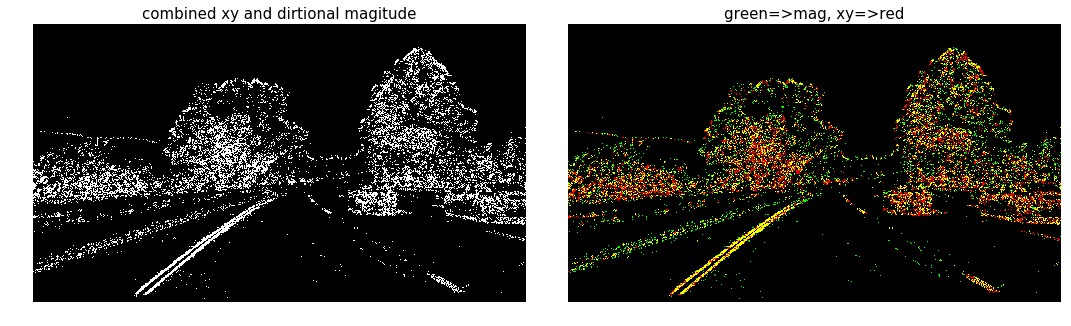

In [10]:
binary_zero = np.zeros_like(binary_xy)
color_combined = np.uint8(np.dstack((binary_zero, binary_mag, binary_xy)) * 255)
binary_thresh = np.zeros_like(binary_xy)
binary_thresh[(binary_mag==1) | (binary_xy==1)] = 1

show_images([binary_thresh, color_combined], 
            ['combined xy and dirtional magitude', 'green=>mag, xy=>red'])

save_example_image(basename, 'binary_thresh', binary_thresh)
save_example_image(basename, 'color_thresh', color_combined)

### Final Pipeline of Threshold Image

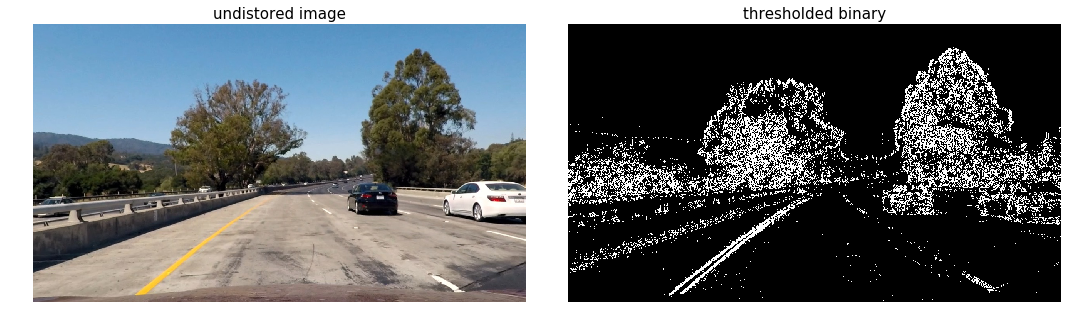

In [11]:
def pipeline_threshold_image(img):
    saturation = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    sobel_x, sobel_y, sobel_mag, sobel_dir = sobel(saturation)
    thresh_sobel_x = thresh_image(sobel_mag, 10, 160)
    thresh_sobel_y = thresh_image(sobel_dir, 10, 160)
    thresh_sobel_mag = thresh_image(sobel_mag, 10, 160)
    thresh_sobel_dir = thresh_image(sobel_dir, 120, 195)
    binary_combined = np.zeros_like(saturation)
    binary_combined[(thresh_sobel_mag==1) & (thresh_sobel_dir==1)] = 1
    binary_combined[(thresh_sobel_x==1) & (thresh_sobel_y==1)] = 1
    return binary_combined

binary_threshed = pipeline_threshold_image(undist)
show_images([undist, binary_threshed], ['undistored image', 'thresholded binary'])

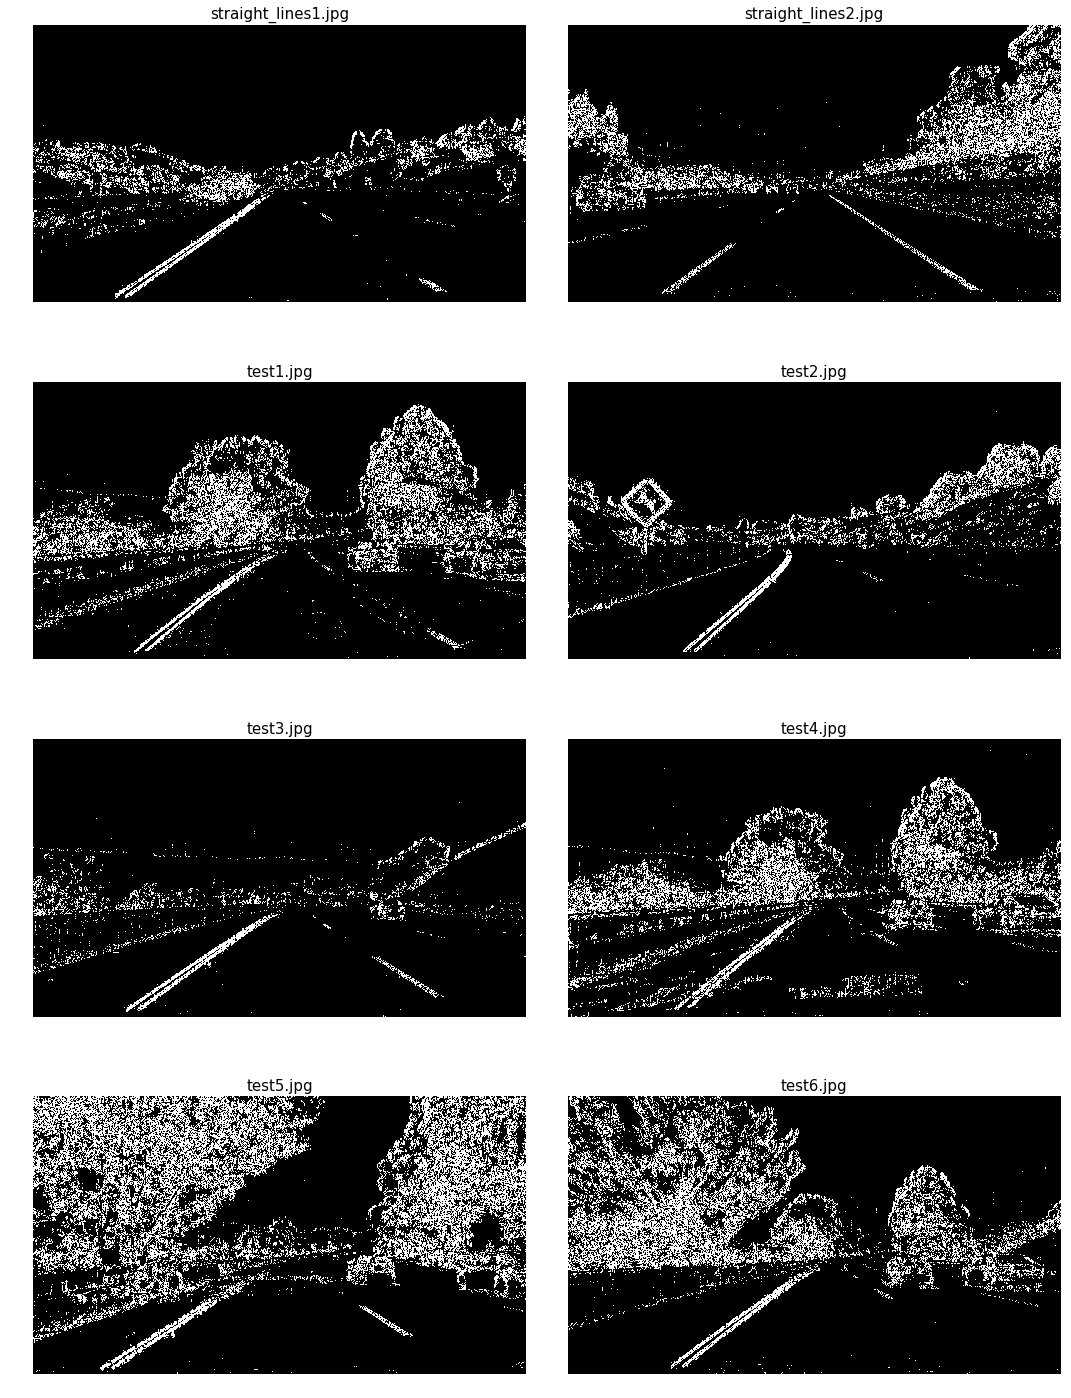

In [12]:
def applyItAndShow(doFunc, imgfiles, savefix=''):
    imgs = []
    labels = []
    for fname in imgfiles:
        img = doFunc(fname)
        label = os.path.basename(fname)
        imgs.append(img)
        labels.append(label)
        if savefix != '':
            save_output_image(label[:-4], savefix, img)
    show_images(imgs, labels)

def doThreshold(fname):
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = pipeline_threshold_image(undist)
    return binary

testfiles = glob.glob('test_images/*.jpg')
applyItAndShow(doThreshold, testfiles, 'thresh')


## 3. Apply a perspective transform to get a bird-eye style view

We has got the perspective transform matrix from `straight_lines1.jpg` in the last section.  We applied it on the binary threshold image to get a bird-style view as follows

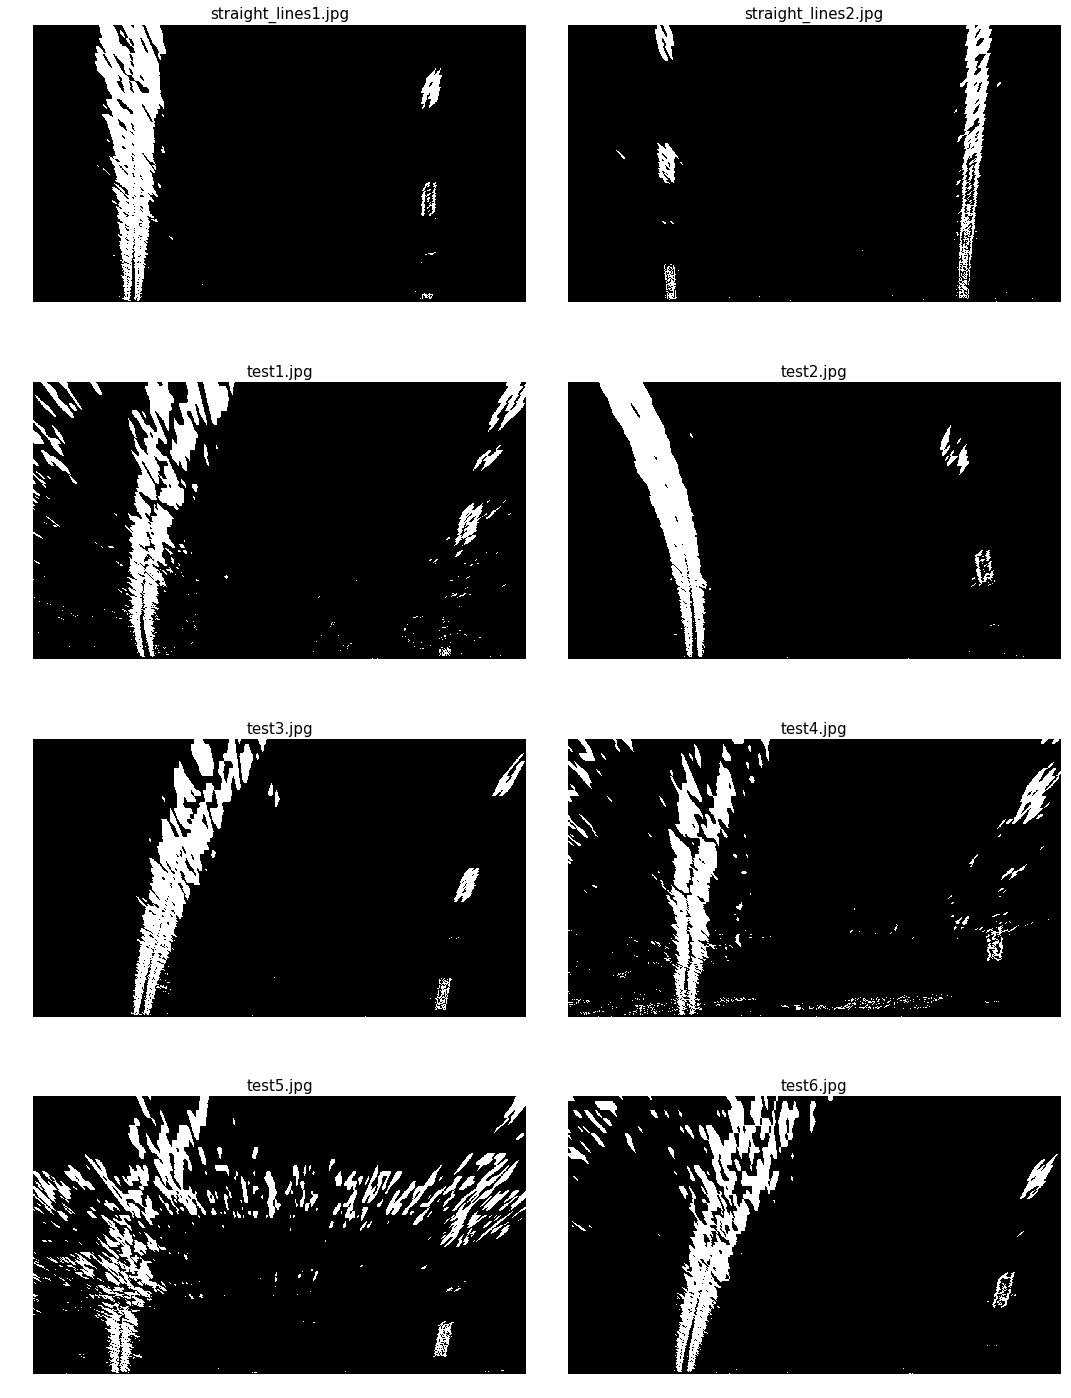

In [13]:
def doBirdView(fname):
    binary = doThreshold(fname)
    warped = cv2.warpPerspective(binary, M, img_size)
    return warped

applyItAndShow(doBirdView, testfiles, savefix='thresh_warped')

## 4. Find Lane Lines by Histogram Methods

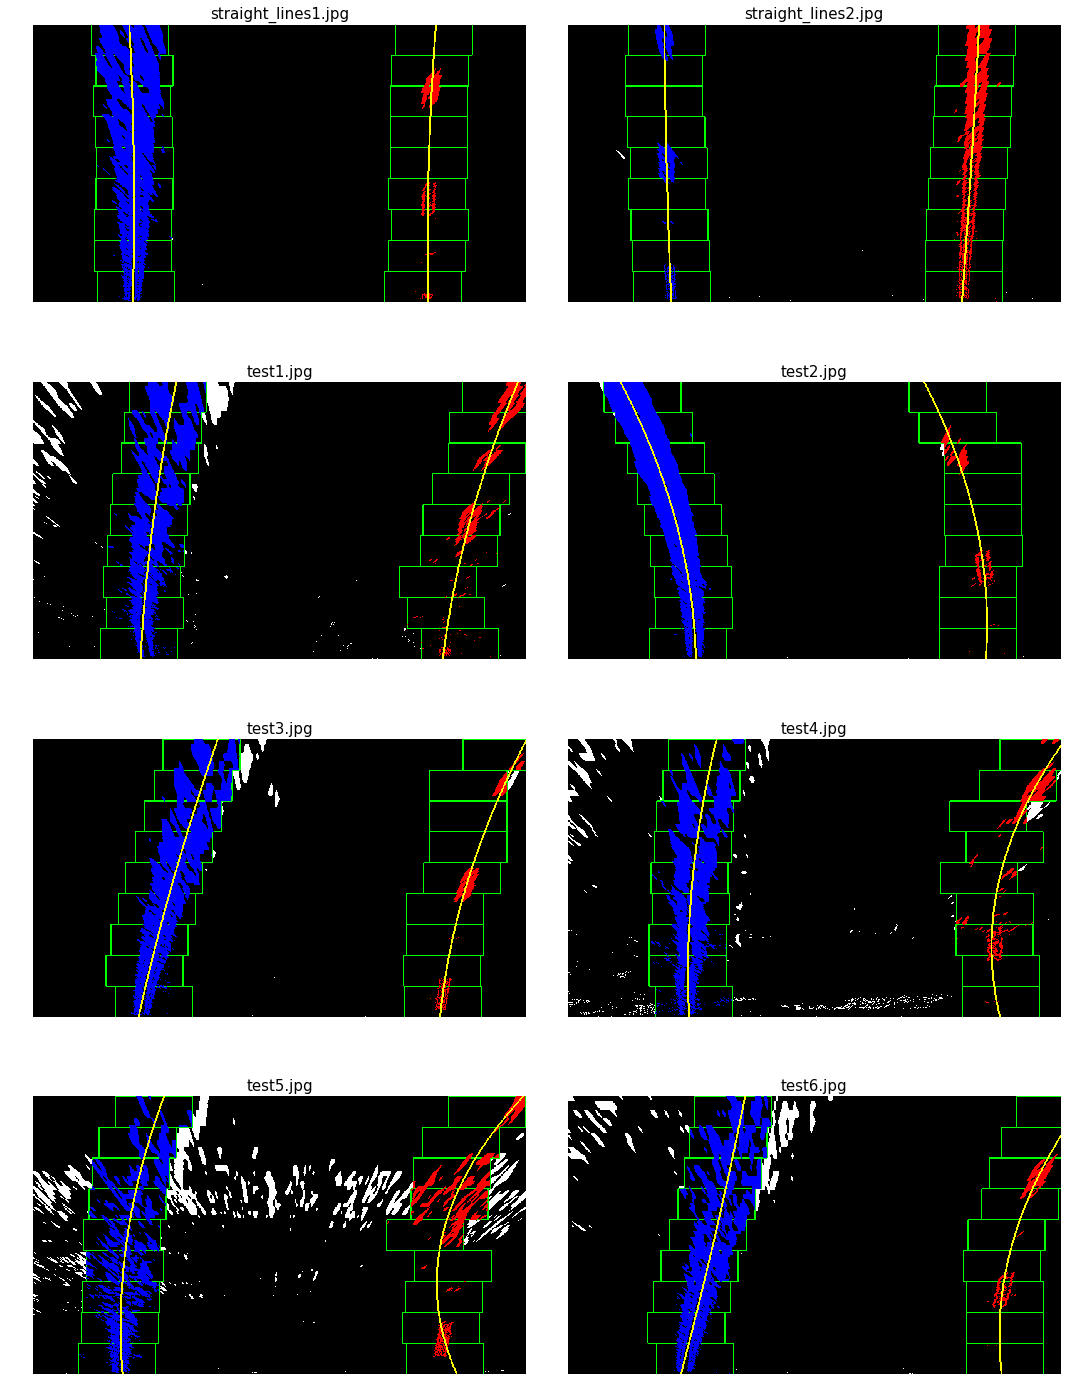

In [14]:
def findLanes(binary_warped, nwindows=9, margin=100, minpix=50):
    '''
        nwindows: the number of sliding windows
        margin: the width of the windows +/- margin
        minpix: minimum number of pixels found to recenter window
        
        return (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    '''
    
    # find starting point by max histogram of the half bottom
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
 
    # draw rectangles
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def drawLanes(out_img, left_fit, right_fit):
    '''
        draw polylines on the out_img according to left_fit and right_fit
    '''
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # draw left lanes
    pts = np.int32(np.vstack((left_fitx, ploty)).T)
    cv2.polylines(out_img, [pts], False, (0,255,255), 3)

    # draw right lanes
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts = np.int32(np.vstack((right_fitx, ploty)).T)
    cv2.polylines(out_img, [pts], False, (0,255,255), 3)

    return out_img


def doDetectAndDrawLanes(fname):
    warped = doBirdView(fname)
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLanes(warped)
    out_img = drawLanes(out_img, left_fit, right_fit)
    return out_img

applyItAndShow(doDetectAndDrawLanes, testfiles, savefix='laneline')


## 5. Calculate the curvature of the land line and the car center position

In [15]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
y_eval = img_size[1] - 5  # 715
midx = img_size[0] // 2   # 640

def calcCurvature(fit):
    y1 = (2 * fit[0] * y_eval + fit[1]) * xm_per_pix / ym_per_pix
    y2 = 2 * fit[0] * xm_per_pix / (ym_per_pix * ym_per_pix)
    curvature = ((1 + y1 * y1) ** (1.5)) / np.abs(y2)
    return curvature

def calcCarCenter(left_fit, right_fit):
    x_left_pix = left_fit[0] * (y_eval**2) + left_fit[1] * y_eval + left_fit[2]
    x_right_pix = right_fit[0] * (y_eval**2) + right_fit[1] * y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix) / 2 - midx) * xm_per_pix
    return position_from_center

for fname in testfiles:
    warped = doBirdView(fname)
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLanes(warped)
    left_curvature = calcCurvature(left_fit)
    right_curvature = calcCurvature(right_fit)
    center_pos = calcCarCenter(left_fit, right_fit)
    label = os.path.basename(fname)
    print("{}: left curvature: {:.1f} m, right curvature: {:.1f} m, pos: {:.2f} m".format(
        label, left_curvature, right_curvature, center_pos))

straight_lines1.jpg: left curvature: 2957.0 m, right curvature: 2504.1 m, pos: 0.01 m
straight_lines2.jpg: left curvature: 7076.6 m, right curvature: 9978.7 m, pos: 0.03 m
test1.jpg: left curvature: 1597.8 m, right curvature: 794.1 m, pos: 0.17 m
test2.jpg: left curvature: 468.3 m, right curvature: 397.8 m, pos: 0.36 m
test3.jpg: left curvature: 1858.5 m, right curvature: 556.0 m, pos: 0.14 m
test4.jpg: left curvature: 810.6 m, right curvature: 247.9 m, pos: 0.41 m
test5.jpg: left curvature: 518.3 m, right curvature: 173.2 m, pos: 0.13 m
test6.jpg: left curvature: 4015.8 m, right curvature: 275.8 m, pos: 0.37 m


In [16]:

for fname in testfiles:
    warped = doBirdView(fname)
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLanes(warped)
    left_curvature = calcCurvature(left_fit)
    right_curvature = calcCurvature(right_fit)
    label = os.path.basename(fname)
    print("{}: left curvature: {:.1f} m, right curvature: {:.1f} m".format(label, left_curvature, right_curvature))

straight_lines1.jpg: left curvature: 2957.0 m, right curvature: 2504.1 m
straight_lines2.jpg: left curvature: 7076.6 m, right curvature: 9978.7 m
test1.jpg: left curvature: 1597.8 m, right curvature: 794.1 m
test2.jpg: left curvature: 468.3 m, right curvature: 397.8 m
test3.jpg: left curvature: 1858.5 m, right curvature: 556.0 m
test4.jpg: left curvature: 810.6 m, right curvature: 247.9 m
test5.jpg: left curvature: 518.3 m, right curvature: 173.2 m
test6.jpg: left curvature: 4015.8 m, right curvature: 275.8 m


## 6. Draw lane line boundaries

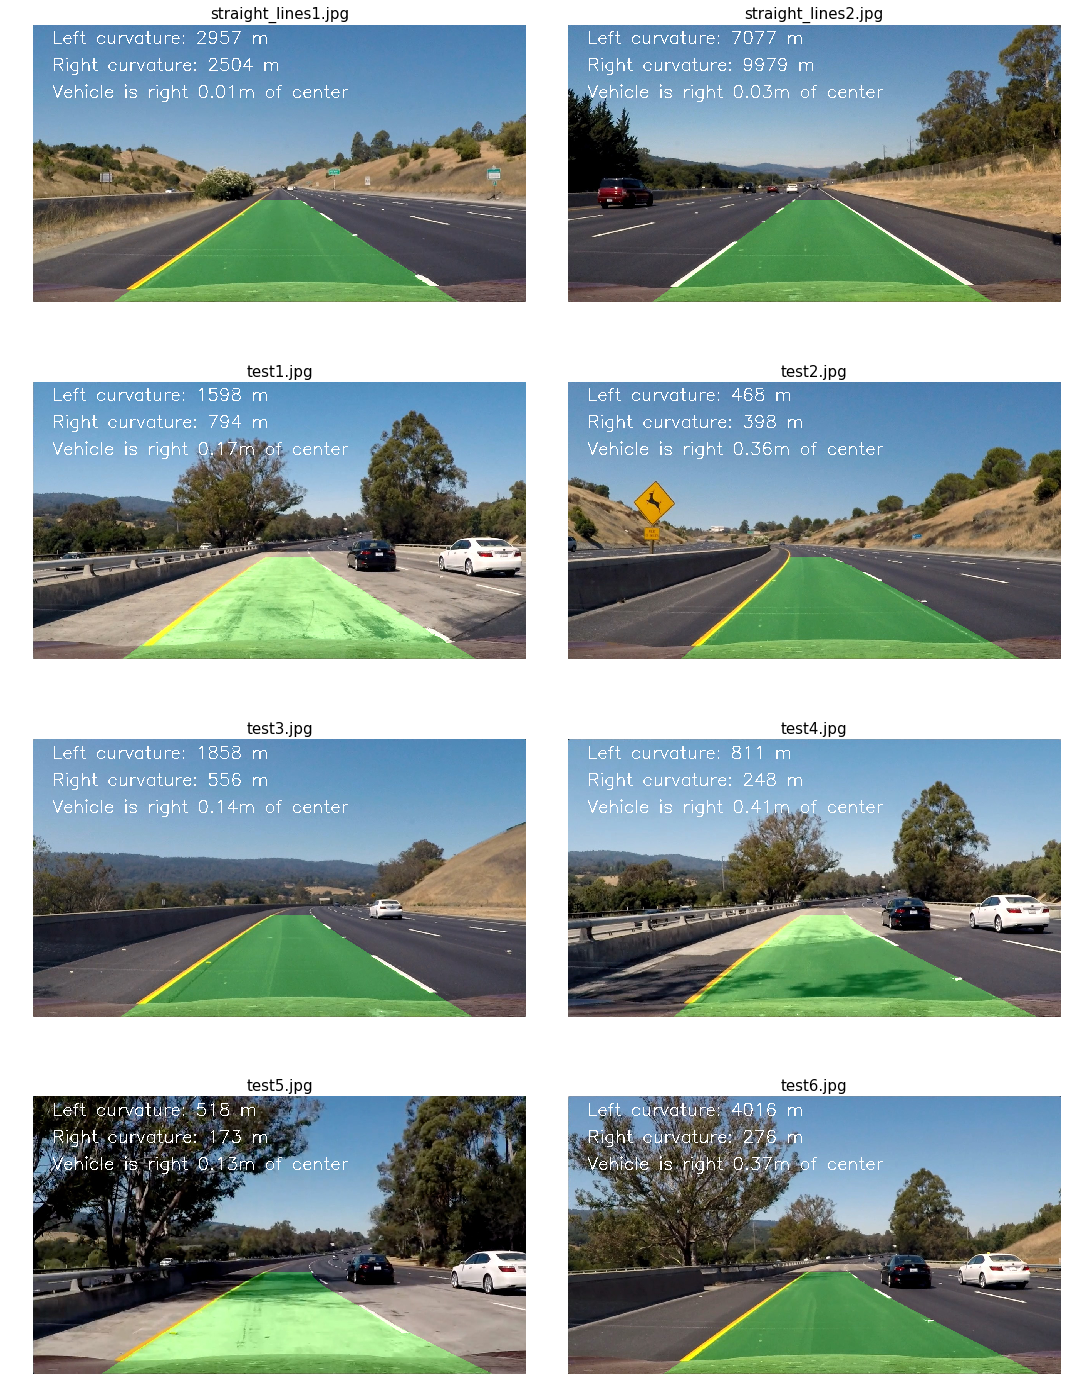

In [17]:
def drawLaneRegion(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    output = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # draw curvatures
    left_curvature = calcCurvature(left_fit)
    right_curvature = calcCurvature(right_fit)
    center_pos = calcCarCenter(left_fit, right_fit)
    if center_pos >= 0:
        pos_text = "right {:.2f}m".format(center_pos)
    else:
        pos_text = "left {:.2f}m".format(-center_pos)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 1.5
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(pos_text), (50, 190), font, fontScale, fontColor, 2)
    return output
    
def doPipeline(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary = pipeline_threshold_image(undist)    
    warped = cv2.warpPerspective(binary, M, img_size)
    left_fit, right_fit, *_ = findLanes(warped)
    output = drawLaneRegion(img, left_fit, right_fit)
    return output

def doDrawLaneOnImage(fname):
    img = cv2.imread(fname)
    output = doPipeline(img)
    return output

applyItAndShow(doDrawLaneOnImage, testfiles, savefix='output')


### Video Output

In [18]:
from moviepy.editor import VideoFileClip

def videoPipeline(inputVideo, outputVideo):
    """
        Process the `inputVideo` frame by frame to find the lane lines, and generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    clip = myclip.fl_image(doPipeline)
    clip.write_videofile(outputVideo, audio=False)

# Project video
output_file = 'output_videos/output_project_video.mp4'
videoPipeline('project_video.mp4', output_file)

[MoviePy] >>>> Building video output_videos/output_project_video.mp4
[MoviePy] Writing video output_videos/output_project_video.mp4


100%|█████████▉| 1260/1261 [05:56<00:00,  3.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_project_video.mp4 



In [20]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))